### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "P_hotel_perc": 0.05,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

15it [00:00, 147.50it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


45it [00:00, 148.82it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


77it [00:00, 152.24it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


111it [00:00, 159.75it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


143it [00:00, 158.88it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


159it [00:01, 142.07it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


188it [00:01, 125.41it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


201it [00:01, 121.85it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


236it [00:01, 143.69it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


271it [00:01, 156.03it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


304it [00:02, 159.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


321it [00:02, 159.66it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


354it [00:02, 138.93it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


369it [00:02, 129.80it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


396it [00:02, 120.64it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


428it [00:03, 138.74it/s]

7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


445it [00:03, 145.34it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


479it [00:03, 156.03it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


512it [00:03, 142.81it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


527it [00:03, 142.54it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


556it [00:03, 125.75it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


569it [00:04, 117.72it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


593it [00:04, 114.99it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5


624it [00:04, 134.04it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


656it [00:04, 145.50it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


688it [00:04, 150.35it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


704it [00:04, 152.32it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


735it [00:05, 130.18it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


749it [00:05, 125.38it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


775it [00:05, 116.89it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


787it [00:05, 112.87it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


816it [00:05, 124.65it/s]

3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


851it [00:06, 146.52it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


885it [00:06, 157.41it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


919it [00:06, 158.89it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


936it [00:06, 159.58it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


969it [00:06, 136.63it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


983it [00:07, 129.52it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1013it [00:07, 133.19it/s]

10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1049it [00:07, 152.57it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1085it [00:07, 163.28it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1119it [00:07, 164.03it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1136it [00:08, 162.59it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1168it [00:08, 134.71it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1182it [00:08, 128.99it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1211it [00:08, 131.15it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1247it [00:08, 151.98it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1283it [00:09, 163.24it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1301it [00:09, 165.97it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1335it [00:09, 153.23it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1351it [00:09, 140.86it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1380it [00:09, 127.57it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1408it [00:10, 128.77it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1442it [00:10, 146.94it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1459it [00:10, 153.15it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1493it [00:10, 158.25it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1525it [00:10, 138.51it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1540it [00:10, 131.63it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1567it [00:11, 122.33it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1580it [00:11, 118.30it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1606it [00:11, 121.82it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1642it [00:11, 148.43it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1675it [00:11, 153.67it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1708it [00:12, 157.67it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1724it [00:12, 158.27it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1756it [00:12, 143.95it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1771it [00:12, 131.69it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1798it [00:12, 121.18it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1832it [00:13, 141.99it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1868it [00:13, 158.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1903it [00:13, 162.92it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1920it [00:13, 163.59it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1954it [00:13, 142.08it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1969it [00:13, 130.25it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1996it [00:14, 119.68it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2029it [00:14, 138.16it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2047it [00:14, 147.53it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2083it [00:14, 159.43it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2118it [00:14, 164.86it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2135it [00:15, 151.31it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2166it [00:15, 132.09it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2180it [00:15, 127.03it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2206it [00:15, 123.20it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2242it [00:15, 147.67it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2276it [00:16, 156.43it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2310it [00:16, 153.75it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2326it [00:16, 138.38it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2355it [00:16, 124.72it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2368it [00:16, 121.17it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2393it [00:17, 118.61it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0


2423it [00:17, 130.77it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2455it [00:17, 142.84it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2489it [00:17, 154.20it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2523it [00:17, 159.95it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2540it [00:17, 157.08it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2556it [00:18, 141.77it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2585it [00:18, 124.25it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2614it [00:18, 131.40it/s]

10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2647it [00:18, 146.05it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2680it [00:19, 151.84it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2696it [00:19, 150.75it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2728it [00:19, 149.61it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2744it [00:19, 141.02it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2772it [00:19, 121.11it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2798it [00:19, 118.21it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2815it [00:20, 130.37it/s]

7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2851it [00:20, 151.07it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2886it [00:20, 160.43it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2903it [00:20, 145.92it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2933it [00:20, 130.43it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2947it [00:21, 119.25it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2972it [00:21, 114.22it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2996it [00:21, 111.51it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3012it [00:21, 123.62it/s]

5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3046it [00:21, 145.14it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3079it [00:21, 152.14it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3112it [00:22, 148.77it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3127it [00:22, 136.53it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3154it [00:22, 121.37it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3167it [00:22, 119.01it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3192it [00:22, 113.49it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3223it [00:23, 131.38it/s]

3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3257it [00:23, 146.07it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3293it [00:23, 159.83it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3310it [00:23, 161.72it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3344it [00:23, 160.88it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3361it [00:24, 142.74it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3390it [00:24, 128.75it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3422it [00:24, 141.80it/s]

10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3458it [00:24, 157.50it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3494it [00:24, 165.90it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3511it [00:24, 166.21it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3545it [00:25, 151.62it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3561it [00:25, 139.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3590it [00:25, 128.27it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3622it [00:25, 140.31it/s]

7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3657it [00:26, 155.63it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3675it [00:26, 161.33it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3710it [00:26, 164.37it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3727it [00:26, 158.84it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3758it [00:26, 129.65it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3772it [00:26, 125.07it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3798it [00:27, 120.45it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3832it [00:27, 142.13it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3868it [00:27, 159.49it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3904it [00:27, 165.52it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3921it [00:27, 148.51it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3937it [00:27, 136.84it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3966it [00:28, 126.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3992it [00:28, 120.76it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4024it [00:28, 138.31it/s]

3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4058it [00:28, 151.91it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4075it [00:28, 156.77it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4111it [00:29, 164.71it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4145it [00:29, 160.78it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4162it [00:29, 144.49it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4191it [00:29, 130.30it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4205it [00:29, 129.33it/s]

10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4239it [00:30, 147.01it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4273it [00:30, 155.88it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4307it [00:30, 160.68it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4324it [00:30, 159.88it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4357it [00:30, 133.25it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4371it [00:31, 125.79it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4397it [00:31, 119.68it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0


4429it [00:31, 138.30it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4463it [00:31, 152.53it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4497it [00:31, 159.44it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4514it [00:32, 156.33it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4546it [00:32, 136.17it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4560it [00:32, 128.18it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4587it [00:32, 119.30it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4600it [00:32, 116.98it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4637it [00:32, 146.22it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4673it [00:33, 160.22it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4707it [00:33, 162.98it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4724it [00:33, 145.49it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4753it [00:33, 129.02it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4767it [00:33, 125.01it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4793it [00:34, 120.48it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4800it [00:34, 140.46it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(100)

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.013191,89767.363342,288783.517817,447.369166,6039.530249,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093049,110.034397,64269.922510,206757.708159,320.280309,4323.870993,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.070527,50063.633725,161055.774877,249.460642,3367.857328,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216066,110.125266,41012.203674,131937.131821,204.328018,2758.630012,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194666,0.020764,9.051534e-36,0.079854,0.295284,110.202212,34744.493506,111773.774852,173.065151,2336.655470,0.931658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1970.0,10.0,3.871357,2200.0,29.124258,3.106485,2.592475e+00,15.008164,49.831381,620.479537,11688.396415,37601.819955,29.233285,503.511224,13.936884
96,1970.0,10.0,3.911055,2200.0,29.684104,3.166200,2.784446e+00,15.285450,50.920200,636.982588,11845.578350,38107.477584,29.543293,510.190427,14.079799
97,1970.0,10.0,3.950754,2200.0,30.248928,3.226445,2.987091e+00,15.564582,52.027047,653.902870,12004.805803,38619.715688,29.853581,516.952400,14.222714
98,1970.0,10.0,3.990452,2200.0,30.818723,3.287222,3.250155e+00,15.907966,53.264066,672.430218,12185.077227,39199.652695,30.236550,525.179244,14.365628


### Figures output

### Figure 3: Components of the total resistance

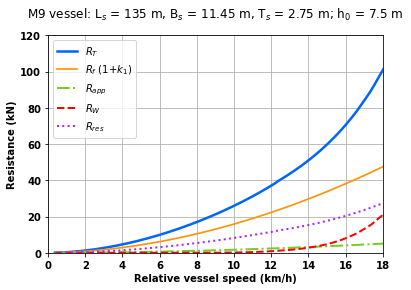

In [9]:
# resistance for water depth h_0 = 7.5 m, 1990
selected = plot_df.query('C_year == 1990 and h_0 == 7.5')

plt.figure(figsize=(6,4))
plt.plot(selected['V_s_km'], selected['R_T'], color='#0165fc', linewidth = 2.5)       # RT, total resistance of the ship,[kN] 
plt.plot(selected['V_s_km'], selected['R_f_one_k1'],color='#ff9408', linewidth = 1.7) # Rf(1+k1), frictional resistance including the hull form factor
plt.plot(selected['V_s_km'], selected['R_APP'],'-.', color='#76cd26',linewidth = 2)   # Rapp, appendage resistance
plt.plot(selected['V_s_km'], selected['R_W'], 'r--', linewidth = 2)                   # Rw, wave resistance
plt.plot(selected['V_s_km'], selected['R_res'],':',color='#aa23ff', linewidth = 2) # Rres, residual resistance
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 120)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')

plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m; h$_0$ = 7.5 m',y=1.05)
plt.savefig('Fig_03.pdf', dpi=600, format='pdf') 


### Figure 5: Total required power

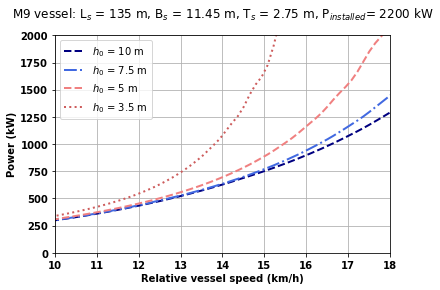

In [10]:

plt.figure(figsize = (6,4))
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'])

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW' ,y=1.05)
plt.savefig('Fig_05.pdf', dpi=600, format='pdf') 


### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5, but squatting is disabled)

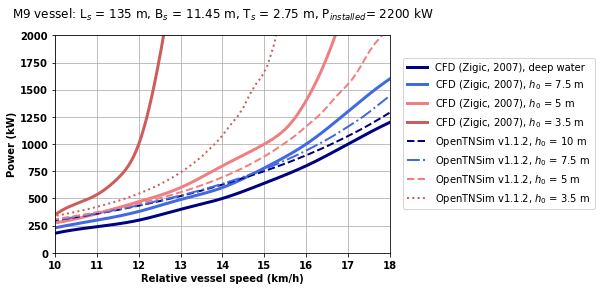

In [11]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Zigic, 2007), deep water', 'CFD (Zigic, 2007), $h_0$ = 7.5 m', 'CFD (Zigic, 2007), $h_0$ = 5 m', 'CFD (Zigic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.1.2, $h_0$ = 10 m', 'OpenTNSim v1.1.2, $h_0$ = 7.5 m', 'OpenTNSim v1.1.2, $h_0$ = 5 m', 'OpenTNSim v1.1.2, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)

plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 


### Figure 8: Emissions as a function of vessel speed: emission rates in g/km versus speed for different water depths

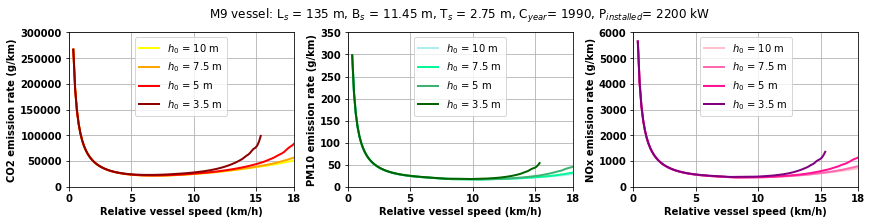

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 300000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 350)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, P$_{installed}$= 2200 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


plt.savefig('Fig_08.pdf', dpi=600, format='pdf')  


### Figure 9: Emissions as a function of engine age: emission rates in g/km versus speed for different engine ages


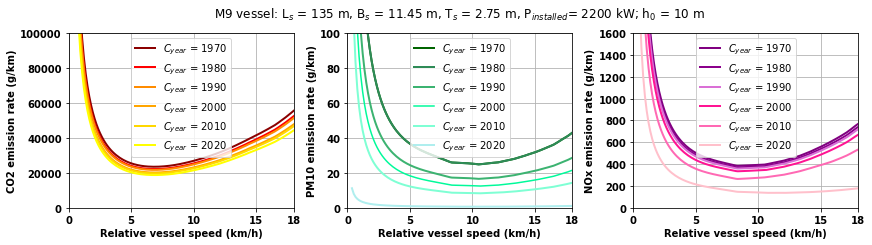

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)   

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)      

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkorange',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)    

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'gold',linewidth = 2.0)      

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)    

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'seagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen')

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'aquamarine',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW; h$_0$ = 10 m',y=1.05)

ax=plt.subplot(133)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'darkmagenta',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'orchid',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('Fig_09.pdf', dpi=600, format='pdf')
